This is a template notebook for exploratory analysis on your organism's QC'ed dataset.

In [1]:
import pandas as pd
import os
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sns.set_style('ticks')

# Load data

In [17]:
data_dir = os.path.join('../data/interim')
os.listdir(data_dir)

['ica_runs',
 '.DS_Store',
 'log_tpm_qc.csv',
 'metadata_qc.csv',
 'log_tpm_norm.csv']

In [18]:
DF_metadata = pd.read_csv(os.path.join(data_dir,'metadata_qc.csv'),index_col=0)
DF_log_tpm = pd.read_csv(os.path.join(data_dir,'log_tpm_qc.csv'),index_col=0)

# Data growth

In [19]:
DF_metadata['ReleaseDate'] = pd.to_datetime(DF_metadata['ReleaseDate'])

In [20]:
local = DF_metadata.loc[[x for x in DF_metadata.index if x.startswith('Paeru')]]

In [21]:
first_date = min(DF_metadata['ReleaseDate'])
last_date = max(DF_metadata['ReleaseDate'])
date_range = pd.date_range(start=first_date,end=last_date,freq='YS')

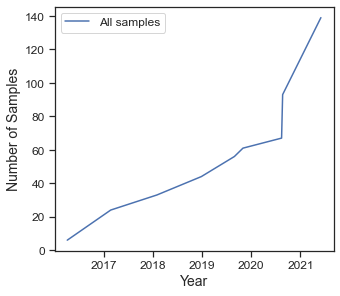

In [24]:
fig,ax = plt.subplots(figsize=(5,5))
growth = DF_metadata['ReleaseDate'].value_counts().sort_index().cumsum()
growth.plot(kind='line', ax=ax,label='All samples' )
plt.xticks(date_range,date_range.strftime('%Y'),rotation=0,ha='center')
ax.tick_params(labelsize=12)
ax.set_xlabel('Year',fontsize=14)
ax.set_ylabel('Number of Samples',fontsize=14)
plt.legend(fontsize=12)

    
#plt.savefig('../figures/datagrowth.svg')

# Hierarchical Clustering

In [25]:
import scipy.cluster.hierarchy as sch
import matplotlib.patches as patches
# change this to get different number of clusters
thresh = .3

# retrieve clusters using fcluster 
corr = DF_log_tpm.corr()
corr.fillna(0,inplace=True)
dist = sch.distance.pdist(corr)
link = sch.linkage(dist, method='complete')
clst = pd.DataFrame(index=DF_log_tpm.columns)
clst['cluster'] = sch.fcluster(link, thresh * dist.max(), 'distance')

#get colors for each cluster
cm = plt.cm.get_cmap('tab20')
clr = dict(zip(clst.cluster.unique(), cm.colors))
clst['color'] = clst.cluster.map(clr)

print('Number of cluster: ', len(clr))

Number of cluster:  14


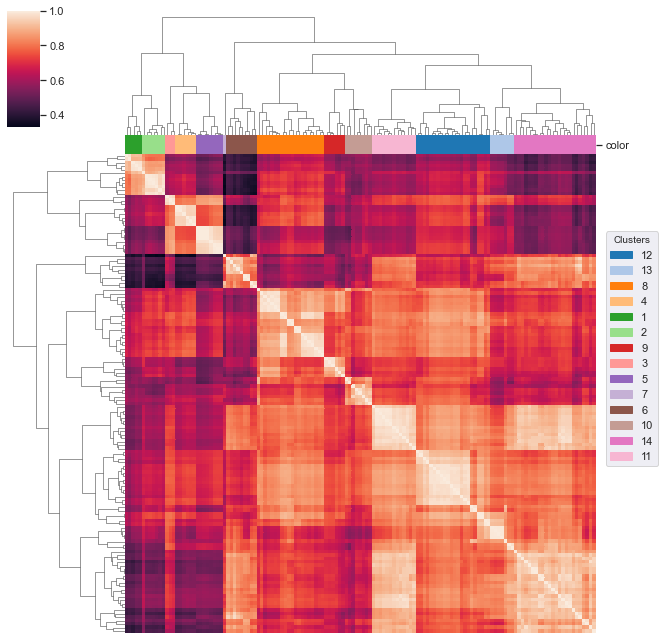

In [26]:
size = 9

legend_TN = [patches.Patch(color=c, label=l) for l,c in clr.items()]

sns.set(rc={'figure.facecolor':'white'})
g = sns.clustermap(DF_log_tpm.corr(), figsize=(size,size), 
                   row_linkage=link, col_linkage=link, col_colors=clst.color,
                  yticklabels=False, xticklabels=False)

l2=g.ax_heatmap.legend(loc='upper left', bbox_to_anchor=(1.01,0.85), handles=legend_TN,frameon=True)
l2.set_title(title='Clusters',prop={'size':10})

# PCA

In [27]:
from sklearn.decomposition import PCA
import numpy as np
sns.set_style('ticks')

First compute principal components.

In [28]:
pca = PCA()
DF_weights = pd.DataFrame(pca.fit_transform(DF_log_tpm.T),index=DF_log_tpm.columns)
DF_components = pd.DataFrame(pca.components_.T,index=DF_log_tpm.index)

Next, plot the cumulative explained variance.

Number of dimensions for 99% of variance: 76


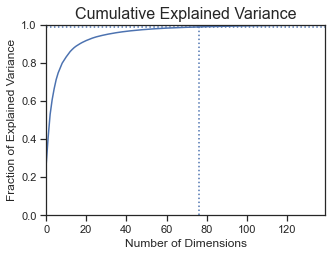

In [29]:
# Set the explained variance threshold
var_cutoff = 0.99

fig,ax = plt.subplots(figsize=(5,3.5))
pca_var = np.cumsum(pca.explained_variance_ratio_)
ax.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax.vlines(dims,0,1,linestyles='dotted')
ax.hlines(var_cutoff,0,len(DF_log_tpm.columns),linestyles='dotted')
ax.set_ylim(0,1)
ax.set_xlim(0,len(DF_log_tpm.columns))
ax.set_ylabel('Fraction of Explained Variance',fontsize=12)
ax.set_xlabel('Number of Dimensions',fontsize=12)
ax.set_title('Cumulative Explained Variance',fontsize=16)
print('Number of dimensions for 99% of variance:',dims)

Finally, plot the first two principle components. The following code colors data by Project Name.

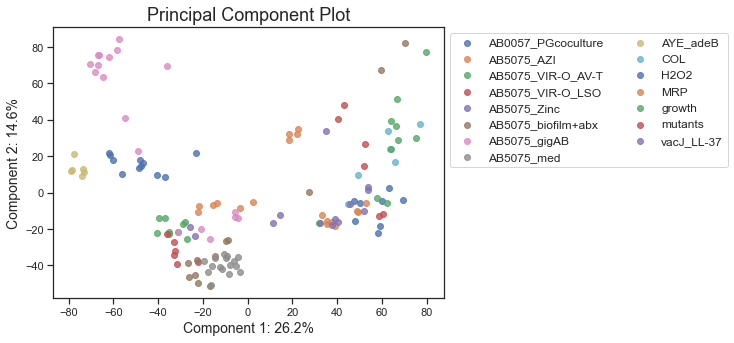

In [30]:
fig,ax = plt.subplots(figsize=(7,5))
for name,group in DF_metadata.groupby('project_name'):
    idx = DF_log_tpm.loc[:,group.index.tolist()].columns.tolist()
    ax.scatter(DF_weights.loc[idx,0],
               DF_weights.loc[idx,1],
               label=name,alpha=0.8)
ax.set_xlabel('Component 1: %.1f%%'%(pca.explained_variance_ratio_[0]*100),fontsize=14)
ax.set_ylabel('Component 2: %.1f%%'%(pca.explained_variance_ratio_[1]*100),fontsize=14)
ax.set_title('Principal Component Plot',fontsize=18)
plt.legend(bbox_to_anchor=(1,1),fontsize=12,ncol=2)

# Normalize to Reference Conditions

In [32]:
project_exprs = []
for name,group in DF_metadata.groupby('project_name'):
    ref_cond = group.reference_condition.unique()
    
    # Ensure that there is only one reference condition per project
    assert(len(ref_cond) == 1)
    ref_cond = ref_cond[0]
    
    # Ensure the reference condition is in fact in the project
    assert(ref_cond in group.condition.tolist())
    
    # Get reference condition sample ids
    ref_samples = group[group.condition == ref_cond].index
    
    # Get reference condition expression
    ref_expr = DF_log_tpm[ref_samples].mean(axis=1)
    
    # Subtract reference expression from project
    project_exprs.append(DF_log_tpm[group.index].sub(ref_expr,axis=0))

DF_log_tpm_norm = pd.concat(project_exprs,axis=1)

In [33]:
DF_log_tpm_norm.head()

,SRX3737100,SRX3737101,SRX3737103,SRX3737104,SRX3737105,SRX3737106,SRX3737107,SRX3737108,SRX3737109,SRX3737110,...,ABNM047,ABNM048,ABNM011,ABNM012,ABNM013,ABNM014,ABNM015,ABNM016,ABNM017,ABNM018
Geneid,,,,,,,,,,,,,,,,,,,,,
ABUW_6001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.305242,1.258212,-0.011878,0.011878,-0.146180,-0.035720,-0.406677,-0.272283,-0.819180,-0.517421
ABUW_6002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.675062,1.715159,0.076541,-0.076541,0.169756,0.026555,0.121908,0.228490,-0.403108,-0.054671
ABUW_6003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.254692,1.254420,0.083129,-0.083129,-0.913299,-0.900846,-0.520846,-0.482845,-1.097177,-0.751511
ABUW_5001,-0.952017,-1.076179,-1.017751,0.136507,-0.013648,0.068553,-0.191413,-1.007134,-1.073281,0.505734,...,1.662634,1.590913,0.042380,-0.042380,-0.056743,-0.300447,-0.164408,-0.347915,-0.753848,-0.364109
ABUW_5002,0.055539,-0.111283,-0.036118,0.107672,-0.039992,0.013536,-0.081216,-0.672627,-0.880489,0.382422,...,0.517091,0.609352,0.107218,-0.107218,0.020481,-0.328213,-0.844554,-0.881745,-1.144642,-0.678814


Uncomment this code to save the log_tpm_norm file

In [35]:
#DF_log_tpm_norm.to_csv(path.join(data_dir,'log_tpm_norm.csv'))

# Expression Variation

(array([ 31., 464., 980., 904., 668., 388., 203., 117.,  77.,  41.,  13.,
          6.,   0.,   1.,   2.]),
 array([0.31207779, 0.51874619, 0.72541459, 0.93208299, 1.13875139,
        1.34541979, 1.55208819, 1.7587566 , 1.965425  , 2.1720934 ,
        2.3787618 , 2.5854302 , 2.7920986 , 2.998767  , 3.2054354 ,
        3.4121038 ]),
 <BarContainer object of 15 artists>)

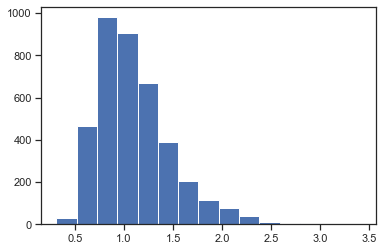

In [36]:
plt.hist(DF_log_tpm_norm.std(axis=1),bins=15)


Text(0, 0.5, 'Standard Deviation')

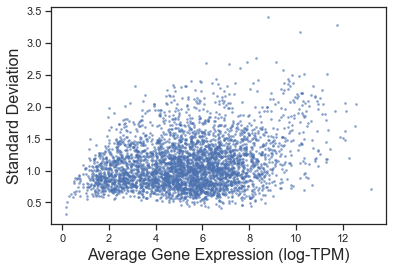

In [37]:
# Plot of average expression against standard deviation of expression (normalized within each project)
plt.scatter(DF_log_tpm.mean(axis=1),DF_log_tpm_norm.std(axis=1),s=3,alpha=0.5)
plt.xlabel('Average Gene Expression (log-TPM)',fontsize=16)
plt.ylabel('Standard Deviation',fontsize=16)